In [1]:
import pandas as pd
import numpy as np
import sqlite3
import re
from sklearn.preprocessing import LabelEncoder
from huggingface_hub import login, logout
from datasets import load_dataset

from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords

from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer


In [2]:
import matplotlib.pyplot as plt

from wordcloud import WordCloud, STOPWORDS

import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

import warnings
warnings.filterwarnings('ignore')

from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

from bs4 import BeautifulSoup
import torch

import re, glob, gc

import logging
logging.getLogger("pytorch_pretrained_bert.tokenization").setLevel(logging.ERROR)


[nltk_data] Downloading package punkt to /Users/Roy/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
engine = sqlite3.connect('./src/data.db')
catalyst = pd.read_sql('SELECT * FROM catalysts', engine)


In [4]:
catalyst


,ticker,disease,stage,date,catalyst
0,SNSE,Various cancers,Phase 1,2023-11-04 00:00:00,Phase 1 safety data reported that a total of 1...
1,REGN,Various cancers,Phase 1,2023-11-04 00:00:00,Phase 1 safety data reported that a total of 1...
2,AUPH,Lupus Nephritis,Phase 3,2023-11-03 00:00:00,Phase 3 data from ASN reported that treated pa...
3,IPHA,Mycosis Fungoides,Phase 2,2023-11-03 00:00:00,Phase 2 data from ASH abstract reported that t...
4,HOWL,Solid Tumors,Phase 1b,2023-11-03 00:00:00,Phase 1/1b preliminary data provided compellin...
...,...,...,...,...,...
3906,SPPI,Colorectal cancer,Approved,2011-04-29 00:00:00,"Approved April 29, 2011."
3907,ASRT,Colorectal cancer,Approved,2011-04-29 00:00:00,"Approved April 29, 2011."
3908,ASRT,Postherpetic neuralgia - shingles,Approved,2011-01-28 00:00:00,"Approved January 28, 2011."
3909,JAZZ,Fibromyalgia,CRL,2010-10-11 00:00:00,"CRL received October 11, 2010."


In [5]:
catalyst.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3911 entries, 0 to 3910
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   ticker    3911 non-null   object
 1   disease   3911 non-null   object
 2   stage     3911 non-null   object
 3   date      3911 non-null   object
 4   catalyst  3911 non-null   object
dtypes: object(5)
memory usage: 152.9+ KB


In [6]:
catalyst['stage'].unique().size


15

In [7]:
catalyst['stage'].unique()


array(['Phase 1', 'Phase 3', 'Phase 2', 'Phase 1b', 'Phase 1/2',
       'Phase 2b', 'Approved', 'BLA Filing', 'Phase 1a', 'Phase 2/3',
       'CRL', 'Phase 2a', 'PDUFA', 'PDUFA priority review', 'NDA Filing'],
      dtype=object)

In [8]:
catalyst['catalyst'][:5]


0    Phase 1 safety data reported that a total of 1...
1    Phase 1 safety data reported that a total of 1...
2    Phase 3 data from ASN reported that treated pa...
3    Phase 2 data from ASH abstract reported that t...
4    Phase 1/1b preliminary data provided compellin...
Name: catalyst, dtype: object

In [65]:
# ## Download pretrained finBERT model
# tokenizer = AutoTokenizer.from_pretrained("dmis-lab/TinySapBERT-from-TinyPubMedBERT-v1.0")
# model = AutoModelForSequenceClassification.from_pretrained("dmis-lab/TinySapBERT-from-TinyPubMedBERT-v1.0")
# classifier = pipeline('feature-extraction', model=model, tokenizer=tokenizer, device=torch.device('cpu'), framework='pt', truncation=True)


In [69]:
# NOTE: change if needed
filtered_words = [i for i in stopwords.words('english') if i not in  ["no", "not"]]
model = SentenceTransformer('dmis-lab/TinySapBERT-from-TinyPubMedBERT-v1.0')


No sentence-transformers model found with name /Users/Roy/.cache/torch/sentence_transformers/dmis-lab_TinySapBERT-from-TinyPubMedBERT-v1.0. Creating a new one with MEAN pooling.


In [70]:
def extract_keywords(doc, n_gram_range=(1,3), stop_words=filtered_words, model=model, top_n=5):

    # Extract candidate words/phrases
    count = CountVectorizer(ngram_range=n_gram_range, stop_words=stop_words).fit([doc])
    candidates = count.get_feature_names_out()


    doc_embedding = model.encode([doc])
    candidate_embeddings = model.encode(candidates)

    distances = cosine_similarity(doc_embedding, candidate_embeddings)
    keywords = [candidates[index] for index in distances.argsort()[0][-top_n:]]

    return keywords


In [100]:
key_words = catalyst['catalyst'].apply(extract_keywords, n_gram_range=(1, 2))


In [101]:
np.ravel(key_words.to_list())


array(['toxicities', '11 adverse', 'limiting toxicities', ...,
       'approved september', '2009', 'september 2009'], dtype='<U33')

In [122]:
## Download pretrained finBERT model
#  "dmis-lab/TinySapBERT-from-TinyPubMedBERT-v1.0"
tokenizer = AutoTokenizer.from_pretrained("roberta-large-mnli")
model = AutoModelForSequenceClassification.from_pretrained("roberta-large-mnli")
classifier = pipeline('sentiment-analysis', model=model, tokenizer=tokenizer, device=torch.device('mps'), framework='pt', truncation=True)


Some weights of the model checkpoint at roberta-large-mnli were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [123]:
flat_kw = np.ravel(key_words.to_list()).tolist()
kw_class = classifier(flat_kw)


In [124]:
kw_df = pd.DataFrame(kw_class)
kw_df['keywords'] = flat_kw
kw_df = kw_df.sort_values(['score'], ascending=False)
kw_df.head()


,label,score,keywords
4156,NEUTRAL,0.979986,levels also
7903,NEUTRAL,0.976525,treatment also
14409,NEUTRAL,0.973259,2020 also
11308,NEUTRAL,0.959464,tolerated however
17704,NEUTRAL,0.957244,2018 also


In [125]:
kw_df.iloc[150:200, :]


,label,score,keywords
6487,ENTAILMENT,0.814724,populations noted
11322,ENTAILMENT,0.813795,deeper level
16214,ENTAILMENT,0.812892,meet endpoints
16209,ENTAILMENT,0.812892,meet endpoints
16388,ENTAILMENT,0.812892,meet endpoints
16134,ENTAILMENT,0.812892,meet endpoints
14320,ENTAILMENT,0.812892,meet endpoints
16797,ENTAILMENT,0.812892,meet endpoints
16802,ENTAILMENT,0.812892,meet endpoints
14376,ENTAILMENT,0.812892,meet endpoints


In [126]:
catalyst['catalyst'][6210//5]


'Phase 2a top-line data demonstrated clinically meaningful reductions in fear, anxiety and avoidance of anxiety-provoking social and performance situations in daily life, as measured by the Liebowitz Social Anxiety Scale (LSAS)'

In [169]:
# compared outputs from BioBERT and RoBERTa to improve our keyword selection to build ground truth labels
bull_words = [
    "preserv", "eval", "improv", "show", "meet", "met", "approv", "present", "observ", "achiev", "attain", "favor", "toler", "treat", "reduc", "reach"]
bear_words = ["toxic", "halt", "fail", "reach"]
bear_words = [f"\b*no \w*{bear_i}\w*" for bear_i in bull_words] + [f"\b*not \w*{bear_i}\w*" for bear_i in bull_words] + bear_words
bull_words = [f"\b*\w*{bull_i}\w*" for bull_i in bull_words]


In [170]:
"|".join(bear_words)


'\x08*no \\w*preserv\\w*|\x08*no \\w*eval\\w*|\x08*no \\w*improv\\w*|\x08*no \\w*show\\w*|\x08*no \\w*meet\\w*|\x08*no \\w*met\\w*|\x08*no \\w*approv\\w*|\x08*no \\w*present\\w*|\x08*no \\w*observ\\w*|\x08*no \\w*achiev\\w*|\x08*no \\w*attain\\w*|\x08*no \\w*favor\\w*|\x08*no \\w*toler\\w*|\x08*no \\w*treat\\w*|\x08*no \\w*reduc\\w*|\x08*no \\w*reach\\w*|\x08*not \\w*preserv\\w*|\x08*not \\w*eval\\w*|\x08*not \\w*improv\\w*|\x08*not \\w*show\\w*|\x08*not \\w*meet\\w*|\x08*not \\w*met\\w*|\x08*not \\w*approv\\w*|\x08*not \\w*present\\w*|\x08*not \\w*observ\\w*|\x08*not \\w*achiev\\w*|\x08*not \\w*attain\\w*|\x08*not \\w*favor\\w*|\x08*not \\w*toler\\w*|\x08*not \\w*treat\\w*|\x08*not \\w*reduc\\w*|\x08*not \\w*reach\\w*|toxic|halt|fail|reach'

In [ ]:
# def special_encode(x, bull_words, bear_words):
#     tmp_x = x.lower()
#     # BULLISH
#     if re.findall(pattern="\b*approv\w*|\b*show\w*|\b*meet\w*", string=x):
#         return 1
#     # BEARISH
#     elif re.findall(pattern="\b*halt\w*|\b*fail\w*|\b*did not reach \w*|\b*no differentiation from placebo \w*|\b*no diff\w*", string=x):
#         return -1
#     # NEUTRAL
#     else:
#         return 0


In [201]:
def special_encode(x, bull_words=bull_words, bear_words=bear_words):
    tmp_x = x.lower()
    # BULLISH
    if re.findall(pattern="|".join(bull_words), string=tmp_x):
        return 1
    # BEARISH
    elif re.findall(pattern="|".join(bear_words), string=tmp_x):
        return -1
    # NEUTRAL
    else:
        return 0


In [202]:
catalyst['label'] = catalyst['catalyst'].apply(special_encode)


<Axes: ylabel='label'>

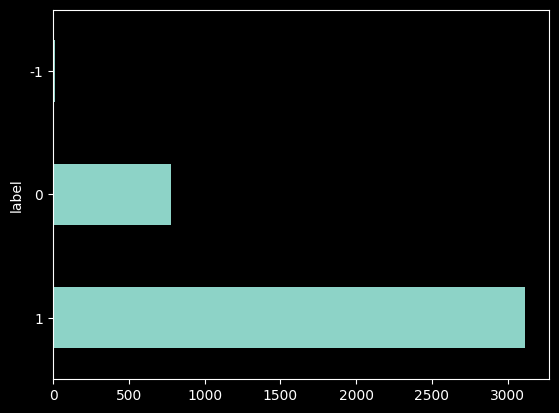

In [207]:
catalyst['label'].value_counts().plot(kind='barh')


<Axes: ylabel='stage'>

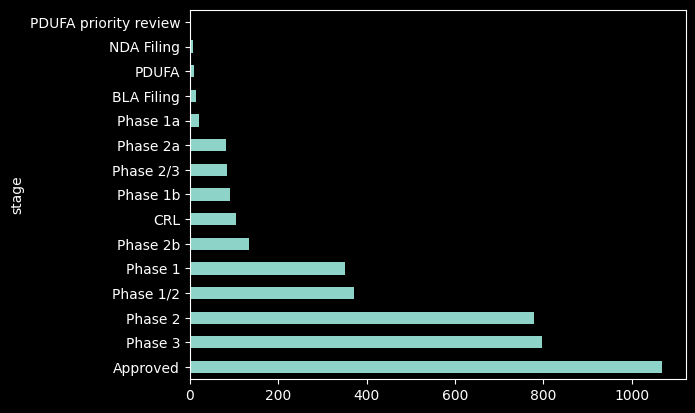

In [208]:
catalyst['stage'].value_counts().plot(kind='barh')


# Archives

In [209]:
df = catalyst.copy(deep=True).sort_values(by=['date']).reset_index(drop=True)
df.head()


,ticker,disease,stage,date,catalyst,label
0,SPPI,Non-Hodgkin’s lymphoma,Approved,2009-09-04 00:00:00,"Approved September 4, 2009.",1
1,JAZZ,Fibromyalgia,CRL,2010-10-11 00:00:00,"CRL received October 11, 2010.",0
2,ASRT,Postherpetic neuralgia - shingles,Approved,2011-01-28 00:00:00,"Approved January 28, 2011.",1
3,ASRT,Colorectal cancer,Approved,2011-04-29 00:00:00,"Approved April 29, 2011.",1
4,SPPI,Colorectal cancer,Approved,2011-04-29 00:00:00,"Approved April 29, 2011.",1


In [210]:
train_size = 0.8
row_len = int(train_size * df.shape[0])
train = df.iloc[:row_len, :]
test = df.iloc[row_len:, :]
print(train.shape)
print(test.shape)
print(catalyst.shape)


(3128, 6)
(783, 6)
(3911, 6)


In [211]:
train


,ticker,disease,stage,date,catalyst,label
0,SPPI,Non-Hodgkin’s lymphoma,Approved,2009-09-04 00:00:00,"Approved September 4, 2009.",1
1,JAZZ,Fibromyalgia,CRL,2010-10-11 00:00:00,"CRL received October 11, 2010.",0
2,ASRT,Postherpetic neuralgia - shingles,Approved,2011-01-28 00:00:00,"Approved January 28, 2011.",1
3,ASRT,Colorectal cancer,Approved,2011-04-29 00:00:00,"Approved April 29, 2011.",1
4,SPPI,Colorectal cancer,Approved,2011-04-29 00:00:00,"Approved April 29, 2011.",1
...,...,...,...,...,...,...
3123,ALNY,Hepatitis B (HBV),Phase 2,2023-06-24 00:00:00,Phase 2 24 or 48 weeks plus up to 48 weeks of ...,1
3124,RLYB,Fetal and neonatal alloimmune thrombocytopenia...,Phase 1b,2023-06-24 00:00:00,Phase 1b data presented at ISTH showed that su...,1
3125,VIR,Hepatitis B,Phase 1,2023-06-24 00:00:00,Phase 1 data showed that treatment has a short...,1
3126,TAK,Alpha-1 Liver Disease,Phase 2,2023-06-24 00:00:00,Phase 2 data presented at EASL showed that at ...,1


In [212]:
train.to_csv("train.csv", index=0)
test.to_csv("test.csv", index=0)
catalyst.to_csv("catalyst.csv", index=0)


In [214]:
login()


In [215]:
dataset = load_dataset("roymgabriel/BioPharma")
dataset


Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['ticker', 'disease', 'stage', 'date', 'catalyst', 'label'],
        num_rows: 3128
    })
    test: Dataset({
        features: ['ticker', 'disease', 'stage', 'date', 'catalyst', 'label'],
        num_rows: 783
    })
})

In [216]:
logout()


Successfully logged out.
